## Example with CNN-LSTM on live BTC close price using the full data

In [1]:
import subprocess
import sys
import warnings
import os
from IPython.display import display, HTML
os.environ["TZ"] = "UTC"
warnings.filterwarnings("ignore")

USE_COLAB = False
if USE_COLAB == True:
    from google.colab import drive
    drive.mount('/content/drive')
    work_dir = '/content/drive/MyDrive/Colab Notebooks/sats4u/'
    secret_data_folder = '/content/drive/MyDrive/Colab Notebooks/crypto_project/crypto_data/'    
else:
    work_dir = '/Users/gabrieletocci/Google Drive/My Drive/Colab Notebooks/sats4u/'
    secret_data_folder = '/Users/gabrieletocci/Google Drive/My Drive/Colab Notebooks/crypto_project/crypto_data/'
    
# if 'darwin' in sys.platform:
#     print('Running \'caffeinate\' on MacOSX to prevent the system from sleeping')
#     subprocess.Popen('caffeinate')

os.chdir(work_dir)
dir_to_save = '/Users/gabrieletocci/Documents/projects/CODE/data_sats4u/'

In [2]:
! pip install -r requirements.txt

In [3]:
import json
import pandas as pd
import numpy as np
from binance.enums import *
import math
from datetime import datetime
import time
import matplotlib.pyplot as plt
import mplfinance as mpf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf
import src.loadcrypto as lc
import src.featbuild as fb
import src.candles2timeseries as c2t
import src.sats2model as s2m
import src.timeutils as tu
import src.sats2backtest as s2b
import re

np.random.seed(420)
os.environ['PYTHONHASHSEED'] = '0'
tf.random.set_seed(420)


## Load Asset Details, Binance client data and Download 15m candles from Binance

In [4]:
data_folder = "data/"
asset_details = pd.read_csv(data_folder + 'asset_details.csv')
secrets_filename = secret_data_folder+'data.json'
crypto = lc.CryptoData(asset_details, data_folder,verbose=False)
crypto.load_binance_client(secrets_filename,data1_str = 'DATA1',data2_str = 'DATA2i',testnet=False)
crypto.trade_time_units(dt=60,kline_size="15m",starting_date = '1 Mar 2017')
tickers=crypto.asset_details["Ticker"]
tickers = list(tickers[tickers=='BTCUSDT'].values)
ldata_df = crypto.load_cryptos(tickers,save = False)

In [5]:
secrets_filename_test = secret_data_folder+'data_test.json'
crypto_test = lc.CryptoData(asset_details,data_folder,verbose = False)
crypto_test.load_binance_client(secrets_filename_test,data1_str = 'DATA1',data2_str = 'DATA2i',testnet=True)
crypto_test.trade_time_units(dt=60,kline_size="15m",starting_date = '1 Mar 2017')
tickers=crypto_test.asset_details["Ticker"]
tickers = list(tickers[tickers=='BTCUSDT'].values)
ldata_df_test = crypto_test.load_cryptos(tickers,save = False)  

### Generate Candles and build features from technical analysis

In [6]:
can_btc = fb.Candles(ldata_df,"Bitcoin")
can_btc.buildfeatures()
ts_btc = c2t.Candle2TimeSeries(can_btc.candles, laststeps = 5000, step_back = 48, candle_step_str = "15m",
                lownorm = 0.2, upnorm= 0.8)

ts_btc.candles2ts(verbose=True)
ts_btc.x_candles = np.asarray(ts_btc.x_candles, dtype=np.float32)
ts_btc.x_time = np.asarray(ts_btc.x_time, dtype=np.float32)

Candles Normalized
Extracted last 5000 steps
Generated time-series
Normalized 'candles_norm' with shape : (5000, 9)
Feature data 'x_candles' with size : 4952
Feature data with time intervals 'x_time' with size : 4952


In [7]:
USE_PRETRAINED = True
PRESAVED_MODELDATE = "220709_08_45"

initial_timestamp = pd.Timestamp(datetime.strptime(PRESAVED_MODELDATE, '%y%m%d_%H_%M'))

if USE_PRETRAINED:
  model_name = f"model/LSTM_CNN_pretrained_{PRESAVED_MODELDATE}"
else:
  model_name = f"model/LSTM_CNN_model"

loaded_model =  s2m.TimeSeries2Model(ts_btc.x_candles, ts_btc.x_time, ts_btc.y, ts_btc.scaler ,split_fraction = 1)
loaded_model.sats2model()
loaded_model.load_model(model_name)
loaded_model.sats2pred(predict_on_test = False)
loaded_model.load_scaler(model_name + '/scaler.sav')
preds = c2t.denorm(loaded_model.scaler,can_btc.candles,loaded_model.preds)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [8]:
new_time_steps = int((can_btc.candles.index[-1] - initial_timestamp)/(can_btc.candles.index[1] - can_btc.candles.index[0]))
new_time_steps

16

,Close,Pred Close
Date,,
2022-05-18 23:15:00,28832.20,28957.444641
2022-05-18 23:30:00,28798.41,29000.098150
2022-05-18 23:45:00,28715.32,28857.872870
2022-05-19 00:00:00,28900.00,28767.204294
2022-05-19 00:15:00,28919.60,28702.600479
...,...,...
2022-07-09 11:45:00,21447.29,21671.278638
2022-07-09 12:00:00,21496.98,21630.886933
2022-07-09 12:15:00,21489.19,21386.360004


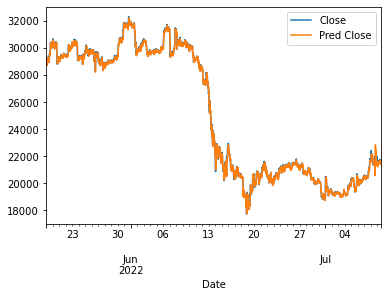

In [9]:
df_preds_true = tu.merge_true_preds(can_btc.candles,preds,period =  +1)
df_preds_true.dropna().plot()
df_preds_true.dropna()

Initial time 2022-07-07 21:15:00
Final time 2022-07-09 12:45:00
Fee: 0.025
----------------------
Buy      34 ( 25 ok 9 ko )
Avg PCT gain: 1.0043462286247173
Avg PCT loss: 0.9971402375262266
Wins  PCT   0.7352941176470589
Avg PCT Gain.    1.0043462286247173
No-op    122
Wallet   1717.017749999988
Drawback -375.73425000000344
Kelly Fraction    0.4724874491086261
Total earned 1717.017749999988


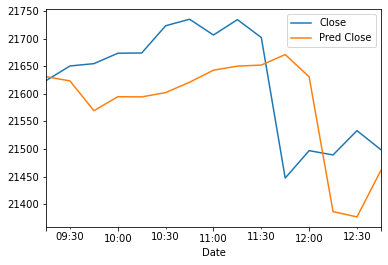

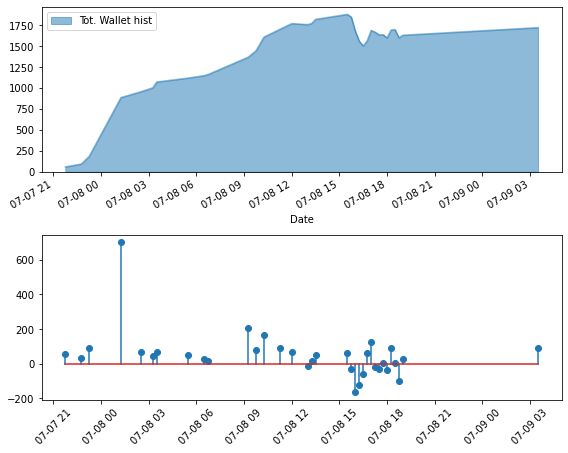

3.5

In [15]:
step_back_val = 2
if new_time_steps > step_back_val :
    df_preds_true.iloc[-new_time_steps:].dropna().plot()

    wallet_hist_df, wallet, kelly_frac = s2b.backtest_df(df_preds_true.iloc[-new_time_steps*10:].dropna(), step_back=+ 2,
                                                    long_short = "long", fee=0.025, cutoff_long =100. ,cutoff_short = 100.0)
    s2b.show_backtest_results(wallet,wallet_hist_df)

In [16]:
def tryexceptwait(func):
  def inner(*args,**kwargs):
        try:
          return func(*args, **kwargs)
        except:
          time.sleep(61)
          return func(*args,**kwargs)
  return inner

@tryexceptwait
def getminutedata(binance_client, ticker,interval, look_back):

  frame = pd.DataFrame(binance_client.get_historical_klines(ticker,interval, look_back + "min ago UTC"))
  frame = frame.iloc[:,:6]
  frame.columns = ['Time', 'Open', 'High', 'Low', 'Close', 'Volume']
  frame = frame.set_index("Time")
  frame.index = pd.to_datetime(frame.index,unit = "ms")
  frame = frame.astype(float)
  return frame

def print_time_status_and_sleep(prev_close_date,delta_date,dt_unit,sleep=True):

  elapsed_minutes = (pd.Timestamp(datetime.now()) -
                     prev_close_date).seconds/dt_unit
  time_condition = 1. < delta_date.seconds/dt_unit - elapsed_minutes < + 1.
  min_till_close = (delta_date.seconds/dt_unit - elapsed_minutes)
  print(f'Current Time: {pd.Timestamp(datetime.now())}')
  print(f'Minutes till Next Close: {min_till_close}')
  if sleep:
    print(f"Sleep for {min_till_close} mins.")
    time.sleep(min_till_close*dt_unit + 10)
    print(f"finished to sleep at {pd.Timestamp(datetime.now())}")


non_decimal = re.compile(r'[^\d.]+')
n_klines = crypto.kline_size
n_klines = non_decimal.sub('',n_klines)

#example: 
# a='123.f.'
# non_decimal.sub('', a )
# a='123'

# print(
#     f'Current limit is {buyprice*(1+avg_change)} or close position in {str(time_until_close)}')
# print(
#     f'Current stop is {buyprice*(1-avg_change)} or close position in {str(time_until_close)}')


In [17]:

investment = 1000.
conservative_kelly = kelly_frac*.5
portfolio = investment
open_position = False
avg_change = 0.004
fee = 0.025
step_back = 2
cutoff_long = 100.

verbose = True

total_wallet_history = []
single_wallet_history = []
single_wallet_hist_deb = []
time_history = []
fill_order_history = []
time_fill_order_history = []
close_order_history = []

wallet = 0.
buys_cnt = 0
buys_cnt_win = 0
buys_cnt_losses = 0
drawback = 0
old_profit_negative = False
old_profits = 0
mean_pct_gain = 0
mean_pct_loss = 0

last_dates = getminutedata(
    crypto.binance_client, tickers[0], crypto.kline_size, '30').index
delta_date = last_dates[-1]-last_dates[-2]
prev_close_date = last_dates[-1]
buffer_delta = 0.05*delta_date

while True:
 
    print_time_status_and_sleep(prev_close_date, delta_date, crypto.dt,sleep = True)
    ldata_df_new = crypto.load_cryptos(tickers,save = False)
    can_btc = fb.Candles(ldata_df_new,"Bitcoin")
    can_btc.buildfeatures()
    ts_btc = c2t.Candle2TimeSeries(can_btc.candles, laststeps = 2000, step_back = 48, candle_step_str = crypto.kline_size,
                    lownorm = 0.2, upnorm= 0.8)

    ts_btc.candles2ts(verbose = False)
    ts_btc.x_candles = np.asarray(ts_btc.x_candles, dtype=np.float32)
    ts_btc.x_time = np.asarray(ts_btc.x_time, dtype=np.float32)
    initial_timestamp = pd.Timestamp(datetime.strptime(PRESAVED_MODELDATE, '%y%m%d_%H_%M'))
    loaded_model =  s2m.TimeSeries2Model(ts_btc.x_candles, ts_btc.x_time, ts_btc.y, ts_btc.scaler, split_fraction = 1)
    loaded_model.sats2model()
    loaded_model.load_model(model_name)
    loaded_model.sats2pred(predict_on_test=False)
    loaded_model.load_scaler(model_name + '/scaler.sav')
    preds = c2t.denorm(loaded_model.scaler, can_btc.candles, loaded_model.preds)
    df_preds_true = tu.merge_true_preds(can_btc.candles,preds,period = +1)
    df_preds_true_shifted = df_preds_true.copy()
    df_preds_true_shifted.iloc[:,0] = df_preds_true.iloc[:,0].shift(step_back,delta_date)
    prev_true_close = df_preds_true_shifted.iloc[-2,0]
    pred_close = df_preds_true_shifted.iloc[-1,1]
    prev_close_date = ldata_df_new["Date"].iloc[-1]
    print_time_status_and_sleep(prev_close_date, delta_date, crypto.dt,sleep=False)

    if open_position == False :

        if prev_true_close*(1+fee/cutoff_long) < pred_close:

            dff = getminutedata(crypto.binance_client, tickers[0],'1m','120')
            if not np.isnan(conservative_kelly):
                buy_quantity = round(portfolio*conservative_kelly / float(dff['Close'].iloc[-1]))
            buy_quantity = 0.001

            balances = crypto_test.binance_client.get_account()['balances']
            balances_dict = {balances[i]["asset"]: float(balances[i]["free"]) for i in 
                            range(len(balances)) if balances[i]["asset"] in tickers[0]}
            balance_before_open = balances_dict["USDT"]

            order = crypto_test.binance_client.create_order(symbol=tickers[0],
                                                        side='BUY',
                                                        type='MARKET',
                                                        quantity= buy_quantity)
                                                        
            order_time = pd.Timestamp(datetime.now())
            est_close_time = df_preds_true_shifted.index[-1]
            open_position = True
            filled_open_price = float(order['fills'][0]['price'])
            filled_open_deb = buy_quantity* filled_open_price

            print('-----------------------------------')
            print(f'Order filled at {str(order_time)}')
            print(f'Order will be closed around {str(est_close_time)}')
            print(f'Filled open price: {filled_open_price}')
            print(f'Previous close price: {prev_true_close}')
            print(f'Predicted close price: {pred_close}')

            while open_position :

                time.sleep(60)
                dff = getminutedata(crypto.binance_client, tickers[0],'1m','2')
                current_price = dff["Close"].iloc[-1]
                current_time = pd.Timestamp(datetime.now())
                time_until_close = (est_close_time - current_time - buffer_delta )

                if verbose:
                    print('--------------------------------')
                    print(f'Current price: {current_price}')
                    print(f'Current time: {current_time}')
                    print(f'Time until close of position: {time_until_close} mins.')
                    print(f'Position will be closed at {time_until_close + current_time}')

                if (time_until_close.seconds/crypto.dt) < 0:
                    print('WARNING: Something must have gone wrong time should not be < 0')
                    print('Restart loop')
                    break
                
                elif (time_until_close.seconds/crypto.dt) < 1 :

                    order = crypto_test.binance_client.create_order(symbol=tickers[0],
                                                                side='SELL',
                                                                type='MARKET',
                                                                quantity= buy_quantity)  
                    open_position = False
                    filled_close_price = float(order['fills'][0]['price'])
                    filled_close_deb = buy_quantity*filled_close_price
                    order_close_time = pd.Timestamp(datetime.now())

                    balances = crypto_test.binance_client.get_account()['balances']
                    balances_dict = {balances[i]["asset"]: float(balances[i]["free"]) for i in 
                            range(len(balances)) if balances[i]["asset"] in tickers[0]}
                    balance_after_close = balances_dict["USDT"]
                    profit_deb = filled_close_deb - filled_open_deb
                    profit = balance_after_close - balance_before_open
                    wallet += profit
                    total_wallet_history.append(wallet)
                    single_wallet_history.append(profit)
                    single_wallet_hist_deb.append(profit_deb)
                    time_history.append(order_close_time)
                    buys_cnt += 1

                    print(f'Position closed at {str(order_close_time)}')
                    print(f'Filled open price: {filled_open_price}')
                    print(f'Filled close price: {filled_close_price}')
                    print(f'Position closed at {str(order_close_time)}')
                    print(f'Profit: {profit}')
                    prev_close_date = getminutedata(crypto.binance_client, tickers[0], crypto.kline_size, n_klines).index[-1]
                
                    if profit > 0:
                        buys_cnt_win += 1
                        old_profit_negative = False
                        mean_pct_gain += filled_close_price / filled_open_price
                    else:
                        buys_cnt_losses += 1
                        mean_pct_loss += filled_close_price / filled_open_price
                        if old_profit_negative:
                            old_profits += profit
                        else:
                            old_profits = profit
                        if old_profits < drawback:
                            drawback = old_profits
                        old_profit_negative = True                    
        else:
            old_profit_negative = False
            old_profits = 0
            dff = getminutedata(
                crypto.binance_client, tickers[0], crypto.kline_size, n_klines)
            prev_close_date = dff.index[-1]
            print(f'Order not filled')
            print(f'Previous true close with fee: {prev_true_close*(1+fee/cutoff_long)}')
            print(f'Predicted close: {pred_close}')
            
        wallet_hist_df = pd.DataFrame(
            np.array([total_wallet_history, single_wallet_history, single_wallet_hist_deb ]).T,
            index=pd.Series(time_history, name="Date"),
            columns=["Tot. Wallet hist", "Single Wallet hist","Single Wallet hust deb" ],
        )
        display(wallet_hist_df)
        wallet_hist_df.to_csv(dir_to_save + "/live_wallet_history.csv")


Current Time: 2022-07-09 12:56:50.555834
Minutes till Next Close: 3.166666666666666
Sleep for 3.166666666666666 mins.
finished to sleep at 2022-07-09 13:00:10.570412
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-09 13:00:38.585591
Minutes till Next Close: 14.366666666666667
Order not filled
Previous true close with fee: 21538.633312500002
Predicted close: 21524.349720132344


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,


Current Time: 2022-07-09 13:00:39.077913
Minutes till Next Close: 14.35
Sleep for 14.35 mins.


In [ ]:
wall_hist = pd.read_csv(dir_to_save + "/live_wallet_history.csv", index_col=0)
wall_hist.index = pd.to_datetime(wall_hist.index)
wall_hist

### Try with Long Short Strategy here. First write functions to make code a bit shorter

In [ ]:
def get_balance(crypto,ticker):

    balance = crypto.binance_client.get_account()['balances']
    balance_dict = {balance[i]["asset"]: float(balance[i]["free"]) for i in
                 range(len(balances)) if balance[i]["asset"] in ticker}
    balance_cash = balances_dict["USDT"]
    return balance_cash


In [ ]:
def create_order_util(crypto, order_side, enter_or_exit, ticker, investment, kelly_frac, use_testnet = True):

    if order_side != "BUY" and order_side != "SELL":
        raise ValueError("order_side can only be BUY or SELL")
    
    if enter_or_exit != "enter" and enter_or_exit != "exit":
        raise ValueError("enter_or_exit can only be enter or exit")

    dff = getminutedata(crypto.binance_client,ticker,"1m",120)
    buy_quantity = round(investment*kelly_frac / float(dff['Close'].iloc[-1]))
    buy_quantity = 0.001

    balance_before_order = get_balance(crypto, ticker)

    if use_testnet == False and order_side == "SELL" and enter_or_exit == "enter":
        #transaction = client.transfer_spot_to_margin(asset='BTC', amount='1.1')
        order = crypto.binance_client.create_margin_order(symbol=ticker, type='ORDER_TYPE_MARKET', side='SIDE_SELL',
                                quantity=buy_quantity, sideEffectType='MARGIN_BUY', isIsolated=False)

    elif use_testnet == False and order_side == "BUY" and enter_or_exit == "exit":
        order = crypto.binance_client.create_margin_order(symbol=ticker, type='ORDER_TYPE_MARKET', side='SIDE_SELL',
                                        quantity=buy_quantity, sideEffectType='AUTO_REPAY', isIsolated=False)
        #transaction = client.transfer_margin_to_spot(asset='BTC', amount='1.1')
        
    else:
        order = crypto.binance_client.create_order(symbol=ticker,
                                                side=order_side,
                                                type='MARKET',
                                                quantity=buy_quantity)
    
    balance_after_order = get_balance(crypto, ticker)

    if order_side == "BUY" and enter_or_exit == "enter":
        open_position = True
        balance_cash = balance_before_order
    elif order_side == "SELL" and enter_or_exit == "exit":
        open_position = False
        balance_cash = balance_after_order
    elif order_side == "SELL" and enter_or_exit == "enter":
        open_position = True
        balance_cash = balance_before_order
    elif order_side == "BUY" and enter_or_exit == "exit":
        open_position = False
        balance_cash = balance_after_order

    order_time = pd.Timestamp(datetime.now())
    filled_price = float(order['fills'][0]['price'])

    return open_position, order, order_time, filled_price, balance_cash

# est_close_time = df_preds_true_shifted.index[-1]
# ticker = tickers[0]
# order_side = "SELL"
# client = crypto
#open_position, order, order_time, filled_open_price, balance_before_open = create_order_util(crypto, order_side, ticker, investment, kelly_frac)

def check_position_util(crypto,est_close_time,buffer_delta,verbose = False):

    time.sleep(60)
    dff = getminutedata(crypto.binance_client,ticker, '1m', '2')                
    current_price = dff["Close"].iloc[-1]
    current_time = pd.Timestamp(datetime.now())
    time_until_close = (est_close_time - current_time - buffer_delta)

    if verbose:
        print('--------------------------------')
        print(f'Current price: {current_price}')
        print(f'Current time: {current_time}')
        print(f'Time until close of position: {time_until_close} mins.')
        print(f'Position will be closed at {time_until_close + current_time}')

    return current_price, current_time, time_until_close

#current_price, current_time, time_until_close = check_open_position(crypto, est_close_time, buffer_delta, verbose = True)


def pnl_after_close(balance_before, balance_after, filled_open_price):

    filled_close_price = float(order['fills'][0]['price'])
    order_close_time = pd.Timestamp(datetime.now())
    profit = balance_before - balance_after
    wallet += profit
    buys_cnt += 1

    print(f'Position closed at {str(order_close_time)}')
    print(f'Filled open price: {filled_open_price}')
    print(f'Filled close price: {filled_close_price}')
    print(f'Position closed at {str(order_close_time)}')
    print(f'Profit: {profit}')

    if profit > 0:
        buys_cnt_win += 1
        old_profit_negative = False
        mean_pct_gain += filled_close_price / filled_open_price
    else:
        buys_cnt_losses += 1
        mean_pct_loss += filled_close_price / filled_open_price
        if old_profit_negative:
            old_profits += profit
        else:
            old_profits = profit
        if old_profits < drawback:
            drawback = old_profits
        old_profit_negative = True

    return wallet, profit, order_close_time

#wallet, profit, order_close_time, open_position = close_position_util(crypto, crypto_test, order_side, quantity_to_close)
#                    
#total_wallet_history.append(wallet)
#single_wallet_history.append(profit)
#time_history.append(order_close_time)
